In [1]:
"""
!pip uninstall keras
!pip uninstall tensorflow
"""

Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/keras-2.9.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-2.9.0
Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.8/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.9.2


In [2]:
"""
!pip install keras==2.3.1
!pip install tensorflow==2.2.0
"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.6/454.6 KB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 20.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Su

# CIFAR10

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## ResNet
### EDA

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
cifar10 = keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train Labels: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test Labels: {dict(zip(unique, counts))}")

170498071/170498071 [==============================] - 14s 0us/step
Train Labels: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Test Labels: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [4]:
y_train.shape

(50000, 1)

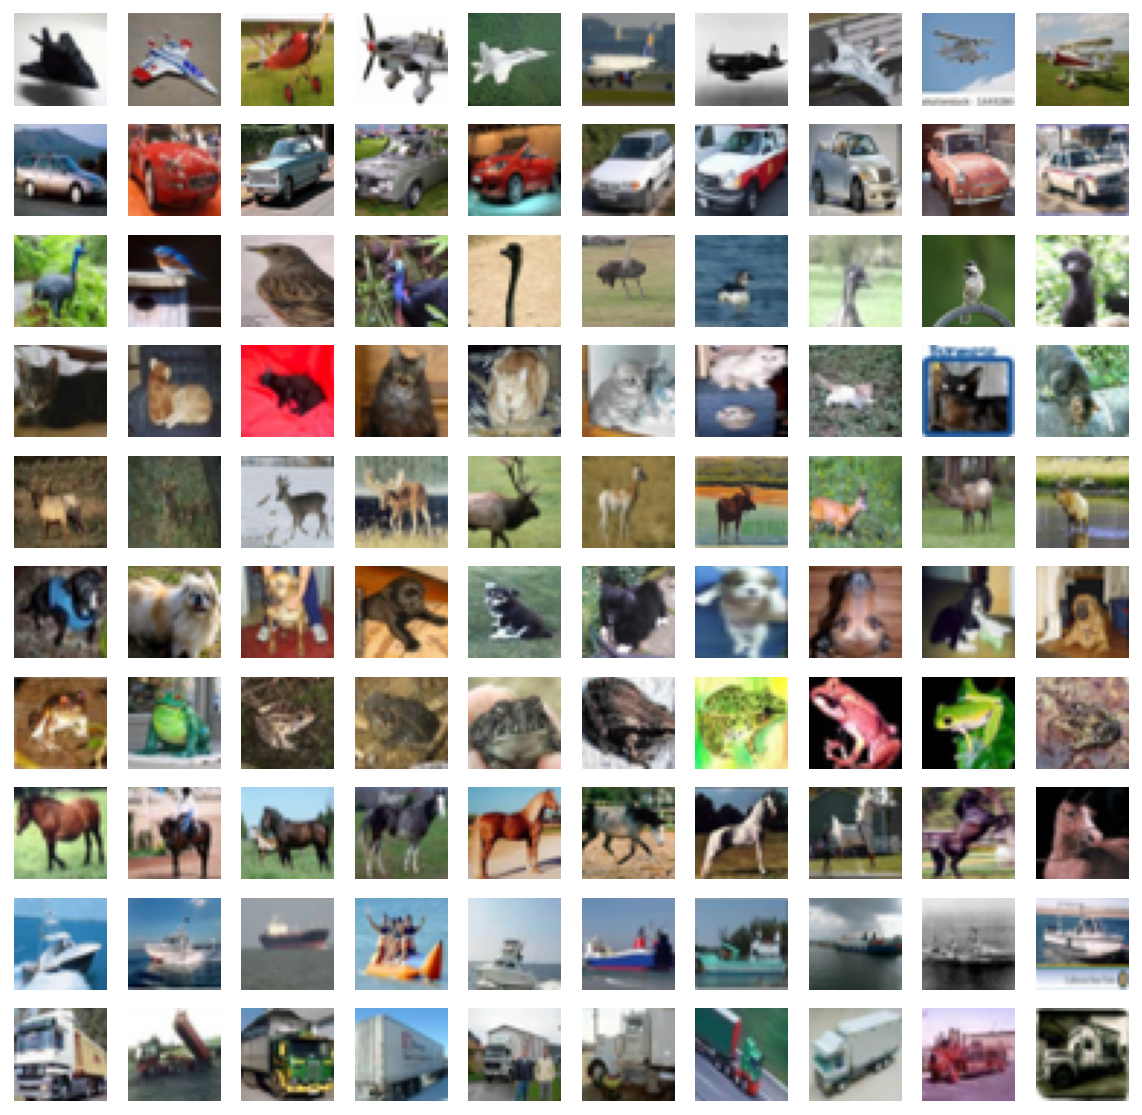

In [5]:
figure =plt.figure(figsize=(10,10))
cols, rows = (10, 10)
k = 1
for i in range(cols):
    for j in np.where(y_train==i)[0][:rows]:
        figure.add_subplot(cols, rows, k)
        plt.imshow(x_train[j], cmap='gray')
        plt.axis('off')
        k += 1

### Modeling

In [6]:
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Flatten, Dense
from keras.regularizers import l2

In [7]:
batch_size = 32 # origin paper trained all networks with bath_size=128
epochs = 200
data_augmentation = True
num_classes = len(np.unique(y_train))

n=3

# Model version
version = 1

# Compute depth from supplied model parameter n
if version == 1:
    depth = n*6+2
elif version == 2:
    depth = n*9+2

# Model name, depth and version
model_type = 'ResNet%d_v%d'%(depth, version)

# Input image dimensions
input_shape = x_train.shape[1:]

# One-hot Encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Normalize data
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# Subtracting pixel mean improves accuracy
subtract_pixel_mean=True
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)


In [8]:
def lr_schedule(epoch):
    # Learning Rate Schedule
    
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print(f"Learning rate: {lr}")
    return lr

In [9]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    # Conv2D-BN-Activation stack builder
    # inputs (tensor) : imput image or previous layer
    # num_filters (int) : Conv2D number of filters
    # kernel_size (int) : Conv2D square kernel dimensions
    # strides (int) : Conv2D square stride dimention
    # activation (string) : Activation name
    # batch_normalization (bool) : wWhether to include BN
    # conv_first (bool) : Conv2D-BN-Activation (True) or bn-activation-conv (False)
    # Returns : x (tensor) as input to the next layer
    
    conv = Conv2D(filters=num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)
                 )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x =Activation(activation)(x)
        x = conv(x)
    return x

In [10]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth-2)%6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
        
    num_filters = 16
    num_res_blocks = int((depth-2)/6)
    
    inputs = keras.Input(shape = input_shape)
    x = resnet_layer(inputs=inputs)
    
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides
                            )
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None
                            )
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False
                                )
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(y)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
    
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy']
             )
model.summary()

Learning rate: 0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_

In [13]:
print(model_type)

ResNet20_v1


In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import os

In [15]:
# Prepare model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' %model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir) # 경로 상의 모든 폴더들을 다 만들어줌
filepath = os.path.join(save_dir, model_name)

In [20]:
# Prepare callbacks for model saving and for learning rate adjustment
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True
                            )
lr_scheduler = LearningRateScheduler(lr_schedule)

# 학습속도 감소 스케줄 전에 지표 개선이 정체되는 경우, 검증 손실이 patience세대 후에 개선되지 않으면 factor만큼 학습속도를 감소
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6
                              )
callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [21]:
if not data_augmentation:
    print("Not using data augmentation.")
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks
             )
else:
    print("Using real-time data augmentation.")
    #This will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        # Set input mean to 0 over the dataset
        featurewise_center=False,
        
        # Set each sample mean to 0
        samplewise_center=False,
        
        # Divide inputs by std of dataset
        featurewise_std_normalization=False,
        
        # Divide each input by its std
        samplewise_std_normalization=False,
        
        # Apply ZCA whitening
        zca_whitening=False,
        
        # Epsilon for ZCA whitening
        zca_epsilon=1e-06,
        
        # Randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        
        # Randomly shift images horizontally
        width_shift_range=0.1,
        
        # Randomly shift images vertically
        height_shift_range=0.1,
        
        # Set range for random shear
        shear_range=0.,
        
        # Set range for random zoom
        zoom_range=0.,
        
        # Set range for random channel shifts
        channel_shift_range=0.,
        
        # Set mode for filling points outside the input boundaries
        fill_mode='nearest',
        
        # Value used for fill_mode = "constant"
        cval=0.,
        
        # Randomly flip images
        horizontal_flip=True,
        
        # Randomly flip images
        vertical_flip=False,
        
        # Set rescaling factor (applied before any other transformation)
        rescale=None,
        
        # Set function that will be applied on each input
        preprocessing_function=None,
        
        # Image data format, either "channels_first" or "channels_last"
        data_format=None,
        
        # Fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0
    )
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    
    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
              validation_data=(x_test, y_test),
              epochs=epochs, verbose=1, steps_per_epoch=250,
              callbacks=callbacks
             )
    
    # Score trained model
    scores = model.evaluate(x_test, y_test, verbose=1)
    print("Test loss:", scores[0])
    print("Test accuracy:", scores[1])

Using real-time data augmentation.
Learning rate: 0.001
Epoch 1/200
249/250 [============================>.] - ETA: 0s - loss: 0.7331 - accuracy: 0.8070
Epoch 1: val_accuracy improved from -inf to 0.77030, saving model to /content/saved_models/cifar10_ResNet20_v1_model.001.h5
250/250 [==============================] - 7s 30ms/step - loss: 0.7327 - accuracy: 0.8071 - val_loss: 0.8978 - val_accuracy: 0.7703 - lr: 0.0010
Learning rate: 0.001
Epoch 2/200
248/250 [============================>.] - ETA: 0s - loss: 0.7489 - accuracy: 0.8057
Epoch 2: val_accuracy did not improve from 0.77030
250/250 [==============================] - 7s 28ms/step - loss: 0.7490 - accuracy: 0.8059 - val_loss: 0.8844 - val_accuracy: 0.7649 - lr: 0.0010
Learning rate: 0.001
Epoch 3/200
248/250 [============================>.] - ETA: 0s - loss: 0.7337 - accuracy: 0.8098
Epoch 3: val_accuracy improved from 0.77030 to 0.77880, saving model to /content/saved_models/cifar10_ResNet20_v1_model.003.h5
250/250 [==========

KeyboardInterrupt: ignored